# Assignment 1: Computational Methods in Finance - MFI 8302
### Strathmore University

#### Lec: Dr. Samuel Chege

#### Name: Ed Joel Odhiambo

#### Adm. no: 095892

## Question 1
* **Stochastic Volatility: Simulation & Distribution Comparison**

In [7]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass
from typing import Tuple, Dict

# Plotting defaults
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True
np.set_printoptions(suppress=True, linewidth=140)

# Parameters
@dataclass
class SVParams:
    mu: float = 0.15         # μ
    vbar: float = 0.04       # \bar v
    deltav: float = 0.2      # δ_v (vol-of-vol)
    kv: float = 1.0          # κ_v (mean-reversion speed)
    S0: float = 0.5          # initial stock price
    v0: float = 0.04         # initial variance (reasonable default)
    T: float = 1.0           # horizon (years)
    steps: int = 2000        # time steps (experiment to get a "good" distribution)
    paths: int = 10_000      # number of simulations (fixed by instruction)
    rho: float = 0.0         # correlation ρ
    seed: int = 12345        # RNG seed for reproducibility


In [8]:
# Correlated brownian motion increments
def correlated_increments(dt: float, rho: float, size: int, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    Z1 = rng.standard_normal(size)
    Z2 = rng.standard_normal(size)
    dW1 = np.sqrt(dt) * Z1
    dW2 = np.sqrt(dt) * (rho * Z1 + np.sqrt(max(1.0 - rho**2, 0.0)) * Z2)
    return dW1, dW2


In [9]:
# Simulation (log-Euler for S, full-truncation Euler for v)
def simulate_sv_terminal(params: SVParams) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simulate S_T and v_T with:
      dS/S = mu dt + sqrt(v) dW1   (integrated via log-Euler with frozen v)
      dv   = kv (vbar - v) dt + deltav sqrt(v) dW2   (full truncation Euler)
    """
    rng = np.random.default_rng(params.seed)
    dt = params.T / params.steps

    S = np.full(params.paths, params.S0, dtype=float)
    v = np.full(params.paths, params.v0, dtype=float)

    for _ in range(params.steps):
        dW1, dW2 = correlated_increments(dt, params.rho, params.paths, rng)
        v_pos = np.maximum(v, 0.0)

        # Log-Euler for S (keeps S>0)
        S *= np.exp((params.mu - 0.5 * v_pos) * dt + np.sqrt(v_pos) * dW1)

        # Full truncation Euler for v
        v += params.kv * (params.vbar - v_pos) * dt + params.deltav * np.sqrt(v_pos) * dW2

    return S, np.maximum(v, 0.0)


In [ ]:
# Lognormal fit from simulated mean/variance
def lognormal_fit_from_moments(samples: np.ndarray) -> Tuple[float, float]:
    """
    Fit LN(mu_L, sigma_L^2) to data by matching mean and variance:
        m = E[X], s2 = Var[X]
        sigma_L^2 = ln(1 + s2/m^2)
        mu_L = ln(m) - 0.5 sigma_L^2
    Returns (mu_L, sigma_L).
    """
    m = float(np.mean(samples))
    s2 = float(np.var(samples, ddof=1))
    if m <= 0 or s2 <= 0:
        return math.log(max(m, 1e-12)), 1e-9
    sigma2 = math.log(1.0 + s2 / (m * m))
    sigmaL = math.sqrt(max(sigma2, 1e-16))
    muL = math.log(m) - 0.5 * sigma2
    return muL, sigmaL

def lognormal_pdf(x: np.ndarray, muL: float, sigmaL: float) -> np.ndarray:
    x = np.asarray(x)
    pdf = np.zeros_like(x, dtype=float)
    mask = x > 0
    z = (np.log(x[mask]) - muL) / sigmaL
    pdf[mask] = (1.0 / (x[mask] * sigmaL * np.sqrt(2*np.pi))) * np.exp(-0.5 * z * z)
    return pdf


In [6]:
# standard and log scales plots
def plot_distribution_with_lognormal(S_T: np.ndarray, title: str, bins: int = 80):
    muL, sigmaL = lognormal_fit_from_moments(S_T)

    # Build x-grid based on data range
    x_min, x_max = float(np.percentile(S_T, 0.1)), float(np.percentile(S_T, 99.9))
    x_min = max(x_min, 1e-6)
    xs = np.linspace(x_min, x_max, 800)
    pdf_fit = lognormal_pdf(xs, muL, sigmaL)

    # Standard scale histogram + fitted pdf
    plt.figure(figsize=(7.5,5))
    counts, edges, _ = plt.hist(S_T, bins=bins, density=True, alpha=0.5, label="Simulated $S_T$")
    plt.plot(xs, pdf_fit, 'r-', lw=2, label="Lognormal fit (matched mean/var)")
    plt.title(title + " (standard scale)")
    plt.xlabel("$S_T$")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Log scale on y-axis (to highlight tails)
    plt.figure(figsize=(7.5,5))
    counts, edges, _ = plt.hist(S_T, bins=bins, density=True, alpha=0.5, label="Simulated $S_T$")
    plt.plot(xs, pdf_fit, 'r-', lw=2, label="Lognormal fit (matched mean/var)")
    plt.yscale('log')
    plt.title(title + " (log scale)")
    plt.xlabel("$S_T$")
    plt.ylabel("Density (log scale)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def summarize(label: str, S_T: np.ndarray, v_T: np.ndarray):
    print(f"{label}:")
    print(f"  S_T: mean={np.mean(S_T):.6f}, std={np.std(S_T, ddof=1):.6f}, min={np.min(S_T):.6f}, max={np.max(S_T):.6f}")
    print(f"  v_T: mean={np.mean(v_T):.6f}, std={np.std(v_T, ddof=1):.6f}, min={np.min(v_T):.6f}, max={np.max(v_T):.6f}")


rho=-0.5:
  S_T: mean=0.582150, std=0.113642, min=0.118681, max=1.159949
  v_T: mean=0.039988, std=0.026235, min=0.000125, max=0.216605


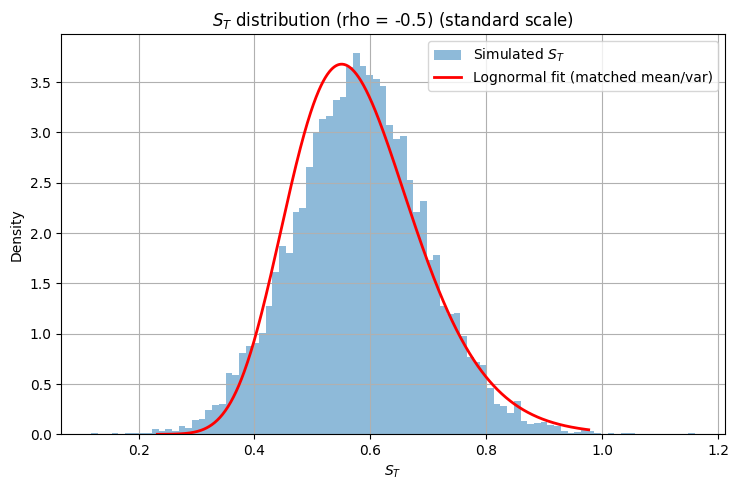

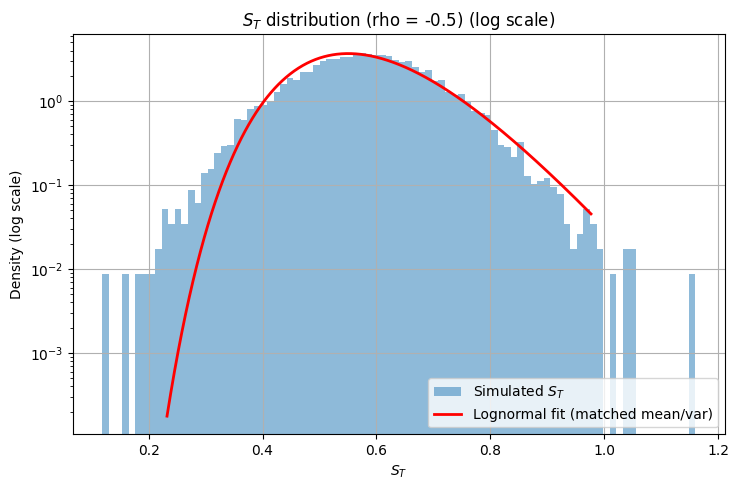

rho=+0.0:
  S_T: mean=0.582267, std=0.118413, min=0.162786, max=1.396055
  v_T: mean=0.040273, std=0.026493, min=0.000144, max=0.233019


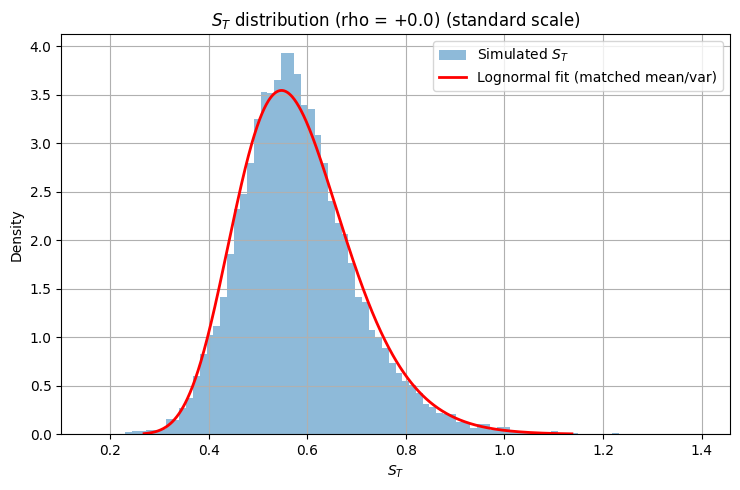

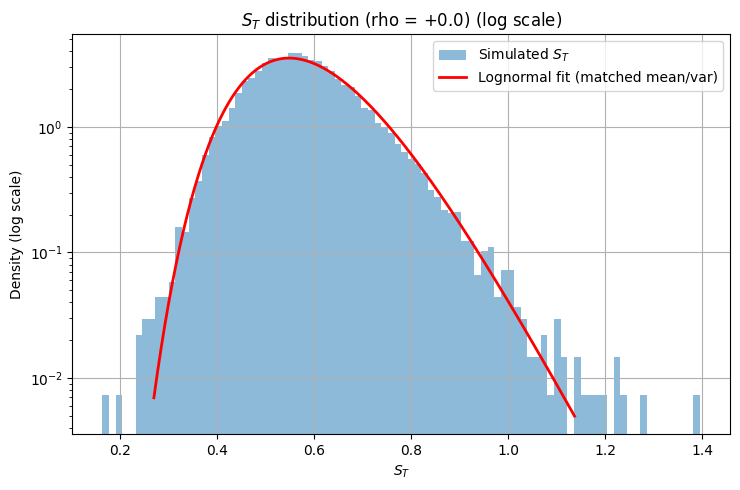

rho=+0.5:
  S_T: mean=0.582287, std=0.123439, min=0.250881, max=1.539708
  v_T: mean=0.040496, std=0.026843, min=0.000603, max=0.216771


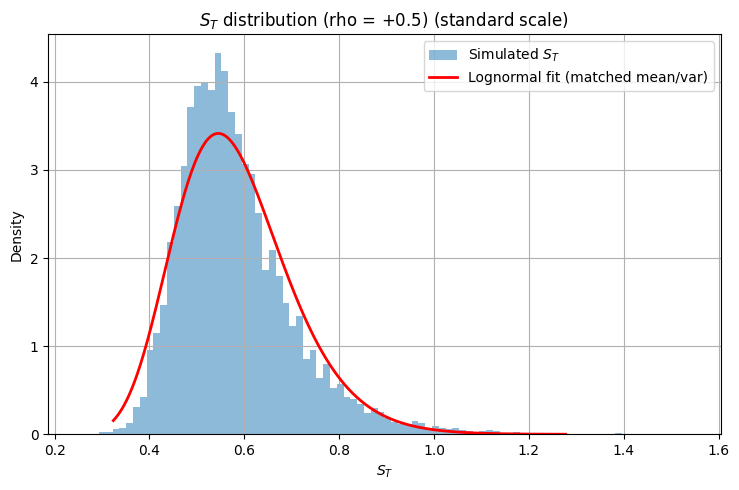

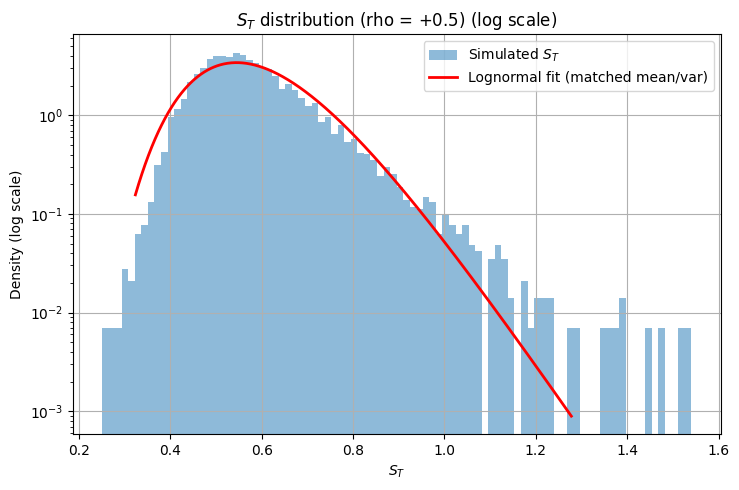

In [10]:
# Vary correlation for rho = (-0.5, 0, 0.5) and sigmna_v = (0.2)
# Base params per instruction
base = SVParams(
    mu=0.15, vbar=0.04, deltav=0.2, kv=1.0, S0=0.5,
    v0=0.04, T=1.0, steps=2000, paths=10_000, seed=2025
)

for rho in [-0.5, 0.0, 0.5]:
    p = SVParams(**{**base.__dict__, "rho": rho})
    S_T, v_T = simulate_sv_terminal(p)
    summarize(f"rho={rho:+.1f}", S_T, v_T)
    plot_distribution_with_lognormal(S_T, title=f"$S_T$ distribution (rho = {rho:+.1f})", bins=90)


* What is a “Good” distribution: 
> If you observe visible time-step bias such as excess mass at 0 or noisy tails, increase steps (e.g., 4000–8000). The log-Euler update for 
𝑆 is already robust; most sensitivity comes from the variance process. Full-truncation Euler + small dt typically produces smooth, stable histograms.

rho=+0.0, deltav=0.5:
  S_T: mean=0.582200, std=0.119844, min=0.092427, max=2.078657
  v_T: mean=0.040619, std=0.067248, min=0.000000, max=0.834814


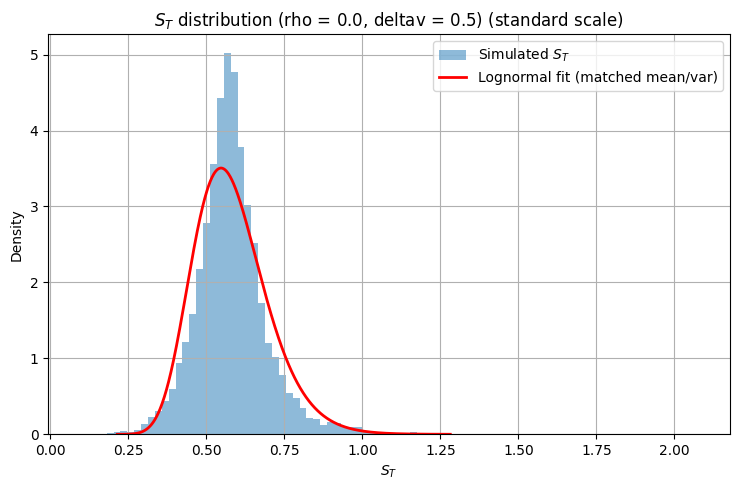

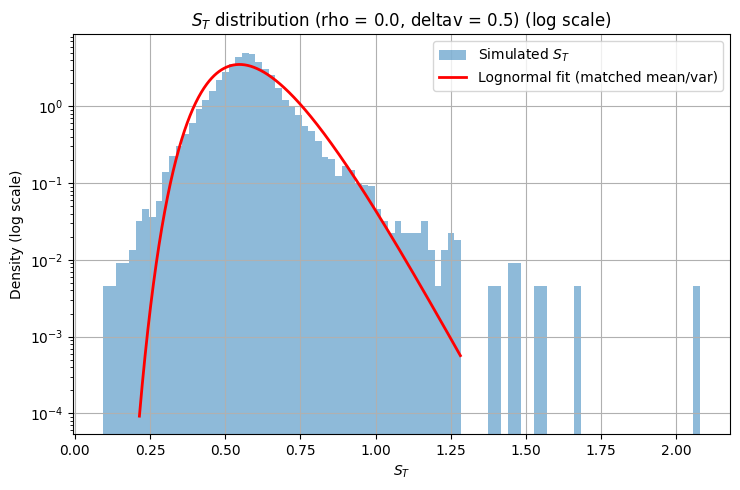

rho=+0.0, deltav=1.0:
  S_T: mean=0.581963, std=0.123952, min=0.047778, max=3.529787
  v_T: mean=0.041065, std=0.135176, min=0.000000, max=2.523904


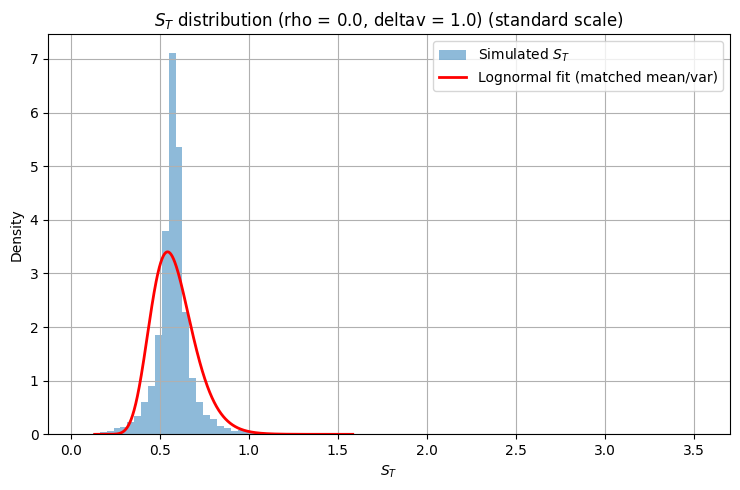

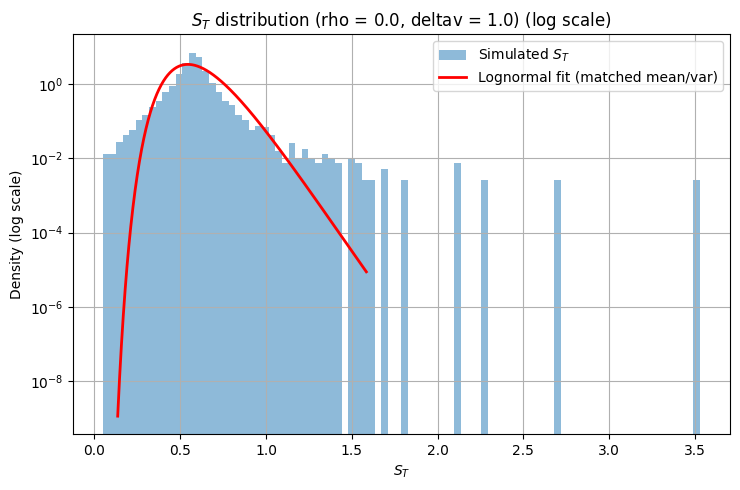

rho=+0.0, deltav=1.5:
  S_T: mean=0.580856, std=0.123715, min=0.025414, max=4.072663
  v_T: mean=0.040848, std=0.193204, min=0.000000, max=4.089678


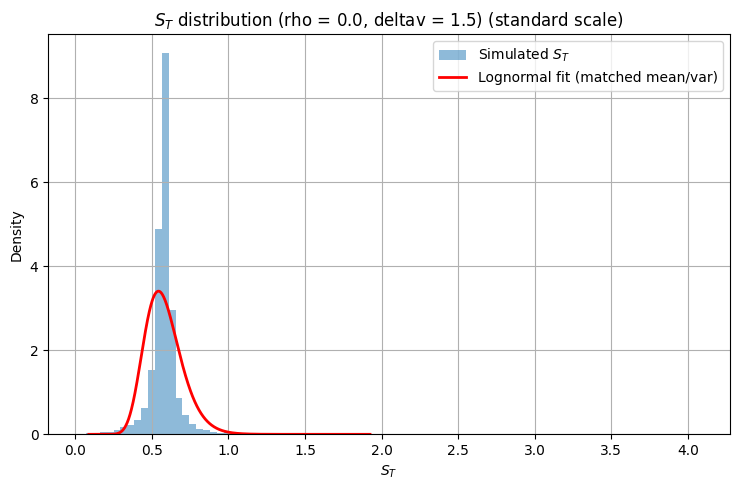

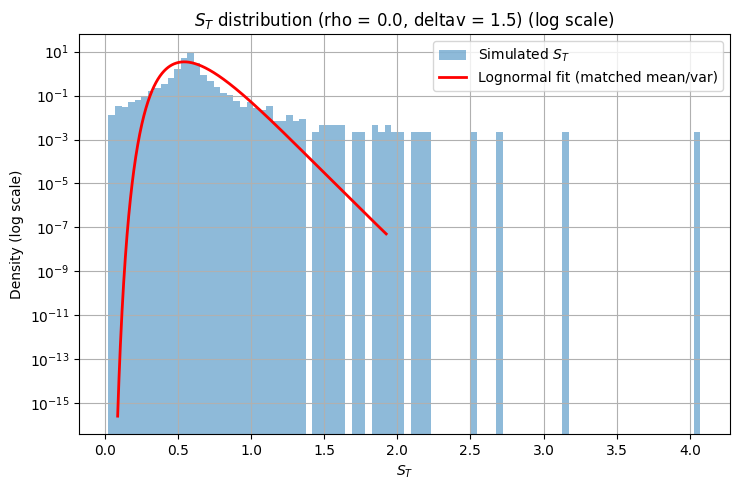

In [11]:
# further experiments: Fix rho = 0, vary sigma_v = (0.5, 1, 1.5)
for dv in [0.5, 1.0, 1.5]:
    p = SVParams(**{**base.__dict__, "rho": 0.0, "deltav": dv})
    S_T, v_T = simulate_sv_terminal(p)
    summarize(f"rho=+0.0, deltav={dv:.1f}", S_T, v_T)
    plot_distribution_with_lognormal(S_T, title=f"$S_T$ distribution (rho = 0.0, deltav = {dv:.1f})", bins=90)


Effect of 
𝜌:

. Negative 
𝜌 (leverage effect) typically fattens the right tail of 
𝑆
𝑇
	​

. (vol spikes often coincide with price drops and recoveries), while positive 
𝜌 can attenuate that asymmetry. On the log scale plot, the tail slopes differ most clearly.

Effect of 
𝛿
𝑣:
	​

Larger 
𝛿
𝑣
	increases stochasticity in 
𝑣 → broader spread and heavier tails for 
𝑆
𝑇
	​

. On standard scale you’ll see wider histograms; on log scale you’ll see heavier tails (slower decay).

. Lognormal comparison:
The red curve uses a lognormal fitted to the sample mean/variance of 
𝑆
𝑇
	​

. Deviations (especially in tails) highlight the impact of stochastic volatility vs simple GBM.

## Question 2

### a) Average-Strike Asian Call under GBM (Euler MC)
> Parameters

S0 = 100

r = 0.05

σ = 0.2

T = 1

Monitoring points 
N=50 (uniform on [0,T])

Monte Carlo paths 
M=100,000

Payoff 
max(ST − Sˉ,0), where Sˉ= 1/N * ∑​Sti from i=1 to N
	​

	​


In [ ]:
# Imports
import numpy as np

# Reproducibility
seed = 2025
rng = np.random.default_rng(seed)


In [13]:
# Given parameters
S0 = 100.0
r  = 0.05
sigma = 0.20
T  = 1.0

# Monte Carlo setup
N = 50           # monitoring points
M = 100_000      # number of paths

dt  = T / N
sqdt = np.sqrt(dt)
disc = np.exp(-r * T)


In [ ]:
# Simulating GBM paths via Euler discretization
# Generate all Z ~ N(0,1) for all time steps and paths
Z = rng.standard_normal(size=(M, N))

# Initialize path matrix for the N monitoring points (exclude t0 per payoff definition)
S = np.empty((M, N), dtype=float)

# Start each path at S0, then propagate N steps
S_prev = np.full(M, S0, dtype=float)
for k in range(N):
    S_next = S_prev * (1.0 + r*dt + sigma*sqdt*Z[:, k])
    S[:, k] = S_next
    S_prev = S_next

# Extract terminal price and average strike over the N monitoring points
ST   = S[:, -1]
Sbar = S.mean(axis=1)


In [15]:
# Compute discounted payoff, point estimate, SE, 95% CI
payoff = np.maximum(ST - Sbar, 0.0)
disc_payoff = disc * payoff

price_est = disc_payoff.mean()
sd = disc_payoff.std(ddof=1)
se = sd / np.sqrt(M)
ci95 = (price_est - 1.96*se, price_est + 1.96*se)

print(f"Average-strike Asian call (Euler MC)")
print(f"Params: S0={S0}, r={r}, sigma={sigma}, T={T}, N={N}, M={M}")
print(f"Price estimate: {price_est:.6f}")
print(f"Std. error   : {se:.6f}")
print(f"95% CI       : ({ci95[0]:.6f}, {ci95[1]:.6f})")


Average-strike Asian call (Euler MC)
Params: S0=100.0, r=0.05, sigma=0.2, T=1.0, N=50, M=100000
Price estimate: 5.759637
Std. error   : 0.026481
95% CI       : (5.707735, 5.811539)


### b) Control variate estimator (geometric strike) for average-strike Asian call

In [16]:
import numpy as np
import math
from scipy.stats import norm

# Inputs same as above
S0 = 100.0
r  = 0.05
sigma = 0.20
T  = 1.0

N = 50            # monitoring points
M = 100_000       # number of Monte Carlo paths
seed = 2025
rng = np.random.default_rng(seed)

dt  = T / N
sqdt = np.sqrt(dt)
disc = np.exp(-r*T)

# Simulate GBM with Euler; paths matrix stores S_{t1},...,S_{tN}
Z = rng.standard_normal(size=(M, N))
S = np.empty((M, N), dtype=float)

S_prev = np.full(M, S0, dtype=float)
for k in range(N):
    S_next = S_prev * (1.0 + r*dt + sigma*sqdt*Z[:, k])   
    S[:, k] = S_next
    S_prev = S_next

ST   = S[:, -1]
Sbar = S.mean(axis=1)
G    = np.exp(np.log(S).mean(axis=1))     

# Payoffs:
X = np.maximum(ST - Sbar, 0.0)  
Y = np.maximum(ST - G,    0.0)  

# Analytic value mu_Y of geometric-strike Asian call
bar_t = T * (N + 1) / (2.0 * N)
sum_min = N*(N+1)*(2*N+1) / 6.0
bar_t_min = (T / N) * (sum_min / (N**2))  


sigma1 = sigma
sigma2 = sigma * math.sqrt(bar_t_min / T)
rho12  = bar_t / math.sqrt(T * bar_t_min)
sigma_M = math.sqrt(max(sigma1**2 + sigma2**2 - 2.0*rho12*sigma1*sigma2, 1e-16))

# Effective "spot" 
mu_lnG = math.log(S0) + (r - 0.5*sigma**2)*bar_t + 0.5*sigma**2 * bar_t_min
G0_star = math.exp(mu_lnG - (r - 0.5*sigma2**2)*T)


d1 = (math.log(S0 / G0_star) + 0.5 * sigma_M**2 * T) / (sigma_M * math.sqrt(T))
d2 = d1 - sigma_M * math.sqrt(T)
muY_analytic = S0 * norm.cdf(d1) - G0_star * norm.cdf(d2)   # = E[e^{-rT}(S_T - G)^+]

# Empirical theta and control variate Z
cov_XY = np.cov(X, Y, ddof=1)[0,1]
var_Y  = np.var(Y, ddof=1)
theta_hat = 0.0 if var_Y == 0.0 else cov_XY / var_Y

# Control variate adjustment
muY_undisc = muY_analytic / disc

Z = X + theta_hat * (muY_undisc - Y)

# Final price estimate and 95% CI 
disc_Z = disc * Z
price_CV = disc_Z.mean()
sd_CV = disc_Z.std(ddof=1)
se_CV = sd_CV / np.sqrt(M)
ci95_CV = (price_CV - 1.96*se_CV, price_CV + 1.96*se_CV)

# For comparison: crude MC from part (a)
disc_X = disc * X
price_MC = disc_X.mean()
sd_MC = disc_X.std(ddof=1)
se_MC = sd_MC / np.sqrt(M)
ci95_MC = (price_MC - 1.96*se_MC, price_MC + 1.96*se_MC)

print("=== Average-Strike Asian Call: Control Variate with Geometric Strike ===")
print(f"Params: S0={S0}, r={r}, sigma={sigma}, T={T}, N={N}, M={M}")
print(f"Theta_hat (empirical): {theta_hat:.6f}")
print(f"Geometric-strike analytic price muY (discounted): {muY_analytic:.6f}")
print(f"Crude MC:  price={price_MC:.6f}, SE={se_MC:.6f}, 95% CI=({ci95_MC[0]:.6f}, {ci95_MC[1]:.6f})")
print(f"CV  Est.:  price={price_CV:.6f}, SE={se_CV:.6f}, 95% CI=({ci95_CV[0]:.6f}, {ci95_CV[1]:.6f})")


=== Average-Strike Asian Call: Control Variate with Geometric Strike ===
Params: S0=100.0, r=0.05, sigma=0.2, T=1.0, N=50, M=100000
Theta_hat (empirical): 0.967588
Geometric-strike analytic price muY (discounted): 5.601172
Crude MC:  price=5.759637, SE=0.026481, 95% CI=(5.707735, 5.811539)
CV  Est.:  price=5.404295, SE=0.000655, 95% CI=(5.403011, 5.405580)


### c) Percentage Comparisons

In [ ]:
# Percentage comparison
d1 = (math.log(S0 / G0_star) + 0.5 * sigma_M**2 * T) / (sigma_M * math.sqrt(T))
d2 = d1 - sigma_M * math.sqrt(T)
muY_discounted = S0 * norm.cdf(d1) - G0_star * norm.cdf(d2)  # = E[e^{-rT} Y]
muY_undisc = muY_discounted / disc                           # = E[Y]

# Point estimates, SEs, CIs
price_MC = disc_X.mean()
sd_MC    = disc_X.std(ddof=1)
se_MC    = sd_MC / np.sqrt(M)
ci95_MC  = (price_MC - 1.96*se_MC, price_MC + 1.96*se_MC)

price_CV = disc_Z.mean()
sd_CV    = disc_Z.std(ddof=1)
se_CV    = sd_CV / np.sqrt(M)
ci95_CV  = (price_CV - 1.96*se_CV, price_CV + 1.96*se_CV)

# Variance reduction (percentage) 
var_reduction_pct = 100.0 * (1.0 - (sd_CV**2)/(sd_MC**2))

print("=== Average-Strike Asian Call: Variance Comparison (Crude MC vs Control Variate) ===")
print(f"Params: S0={S0}, r={r}, sigma={sigma}, T={T}, N={N}, M={M}")
print(f"Theta_hat (empirical)           : {theta_hat:.6f}")
print(f"Geometric-strike analytic price : {muY_discounted:.6f}  (discounted)")
print("")
print(f"Crude MC  -> Price={price_MC:.6f},  SE={se_MC:.6f},  95% CI=({ci95_MC[0]:.6f}, {ci95_MC[1]:.6f})")
print(f"ControlVar-> Price={price_CV:.6f},  SE={se_CV:.6f},  95% CI=({ci95_CV[0]:.6f}, {ci95_CV[1]:.6f})")
print("")
print(f"Per-path variance (disc*X) = {sd_MC**2:.6e}")
print(f"Per-path variance (disc*Z) = {sd_CV**2:.6e}")
print(f"Variance reduction (CV vs MC): {var_reduction_pct:.2f}%")


=== Average-Strike Asian Call: Variance Comparison (Crude MC vs Control Variate) ===
Params: S0=100.0, r=0.05, sigma=0.2, T=1.0, N=50, M=100000
Theta_hat (empirical)           : 0.967588
Geometric-strike analytic price : 5.601172  (discounted)

Crude MC  -> Price=5.759637,  SE=0.026481,  95% CI=(5.707735, 5.811539)
ControlVar-> Price=5.404295,  SE=0.000655,  95% CI=(5.403011, 5.405580)

Per-path variance (disc*X) = 7.012253e+01
Per-path variance (disc*Z) = 4.294525e-02
Variance reduction (CV vs MC): 99.94%


### d) Extensions: vary N, M, σ; plot CI width vs M and summarize effects

In [20]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7.2, 5.0)
plt.rcParams["axes.grid"] = True
np.set_printoptions(suppress=True, linewidth=140)

# --- Euler GBM for average-strike Asian (discrete monitoring) ---
def simulate_paths_euler(S0, r, sigma, T, N, M, rng):
    """
    Euler scheme for GBM:
      S_{k+1} = S_k (1 + r dt + sigma sqrt(dt) Z_k),  Z ~ N(0,1)
    Returns matrix S of shape (M, N) with the N monitoring points (excluding S0).
    """
    dt  = T / N
    sqdt = np.sqrt(dt)
    Z = rng.standard_normal(size=(M, N))
    S = np.empty((M, N), dtype=float)
    S_prev = np.full(M, S0, dtype=float)
    for k in range(N):
        S_next = S_prev * (1.0 + r*dt + sigma*sqdt*Z[:, k])
        S[:, k] = S_next
        S_prev = S_next
    return S  # columns: t1..tN

# --- Average-strike (arithmetic & geometric) payoffs X, Y ---
def asian_arith_geom_payoffs(S):
    ST   = S[:, -1]
    Sbar = S.mean(axis=1)
    G    = np.exp(np.log(S).mean(axis=1))
    X = np.maximum(ST - Sbar, 0.0)  # target (arithmetic strike)
    Y = np.maximum(ST - G,    0.0)  # control (geometric strike)
    return X, Y

# --- Analytic price of geometric-strike Asian call (discounted) ---
def geom_strike_price_discounted(S0, r, sigma, T, N):
    """
    Value = E[e^{-rT} (S_T - G)^+], with discrete monitoring t_i = iT/N.
    Margrabe-style: build effective vols & correlation between ln S_T and ln G,
    then price "exchange option" S_T vs G using G0* and sigma_M.
    """
    # Moments of discrete times
    bar_t     = T * (N + 1) / (2.0 * N)
    sum_min   = N*(N+1)*(2*N+1) / 6.0
    bar_t_min = (T / N) * (sum_min / (N**2))  # = T*(N+1)*(2N+1)/(6N^2)

    sigma1 = sigma
    sigma2 = sigma * math.sqrt(bar_t_min / T)
    rho12  = bar_t / math.sqrt(T * bar_t_min)
    sigma_M = math.sqrt(max(sigma1**2 + sigma2**2 - 2.0*rho12*sigma1*sigma2, 1e-16))

    # Effective spot G0* by matching E[ln G_T]
    mu_lnG  = math.log(S0) + (r - 0.5*sigma**2)*bar_t + 0.5*sigma**2 * bar_t_min
    G0_star = math.exp(mu_lnG - (r - 0.5*sigma2**2)*T)

    d1 = (math.log(S0 / G0_star) + 0.5 * sigma_M**2 * T) / (sigma_M * math.sqrt(T))
    d2 = d1 - sigma_M * math.sqrt(T)
    # Discount already embedded by construction of exchange logic
    return S0 * norm.cdf(d1) - G0_star * norm.cdf(d2)  # discounted geometric-strike value

# --- One-shot estimator for both crude MC and Control Variate (returns stats) ---
def estimate_asian_avg_strike(S0, r, sigma, T, N, M, seed=2025):
    rng  = np.random.default_rng(seed)
    disc = math.exp(-r*T)
    # Simulate paths and compute payoffs
    S = simulate_paths_euler(S0, r, sigma, T, N, M, rng)
    X, Y = asian_arith_geom_payoffs(S)

    # Crude MC (discount later)
    disc_X = disc * X
    price_MC = disc_X.mean()
    sd_MC    = disc_X.std(ddof=1)
    se_MC    = sd_MC / math.sqrt(M)
    ci_MC    = (price_MC - 1.96*se_MC, price_MC + 1.96*se_MC)

    # Control variate using analytic muY (discounted)
    muY_disc = geom_strike_price_discounted(S0, r, sigma, T, N)
    muY_undisc = muY_disc / disc            # E[Y] (undiscounted)
    # Empirical theta
    cov_XY = np.cov(X, Y, ddof=1)[0,1]
    var_Y  = np.var(Y, ddof=1)
    theta  = 0.0 if var_Y == 0 else cov_XY / var_Y

    Z = X + theta * (muY_undisc - Y)        # CV (undiscounted)
    disc_Z = disc * Z
    price_CV = disc_Z.mean()
    sd_CV    = disc_Z.std(ddof=1)
    se_CV    = sd_CV / math.sqrt(M)
    ci_CV    = (price_CV - 1.96*se_CV, price_CV + 1.96*se_CV)

    # Variance reduction %
    var_reduction_pct = 100.0 * (1.0 - (sd_CV**2)/(sd_MC**2))

    return {
        "price_MC": price_MC, "se_MC": se_MC, "ci_MC": ci_MC, "sd_MC": sd_MC,
        "price_CV": price_CV, "se_CV": se_CV, "ci_CV": ci_CV, "sd_CV": sd_CV,
        "theta": theta, "muY_disc": muY_disc, "var_red_pct": var_reduction_pct
    }


M        Price_MC   CIw_MC      Price_CV   CIw_CV      VarRed%
   1000    5.54204    0.971580    5.40425    0.024402     99.94
   2000    5.50673    0.708719    5.40367    0.017225     99.94
   5000    5.68946    0.461261    5.40284    0.011191     99.94
  10000    5.70041    0.327588    5.40353    0.008086     99.94
  20000    5.72640    0.230899    5.40335    0.005773     99.94
  50000    5.76999    0.146532    5.40480    0.003658     99.94
 100000    5.75964    0.103804    5.40430    0.002569     99.94
 200000    5.75694    0.073358    5.40493    0.001799     99.94


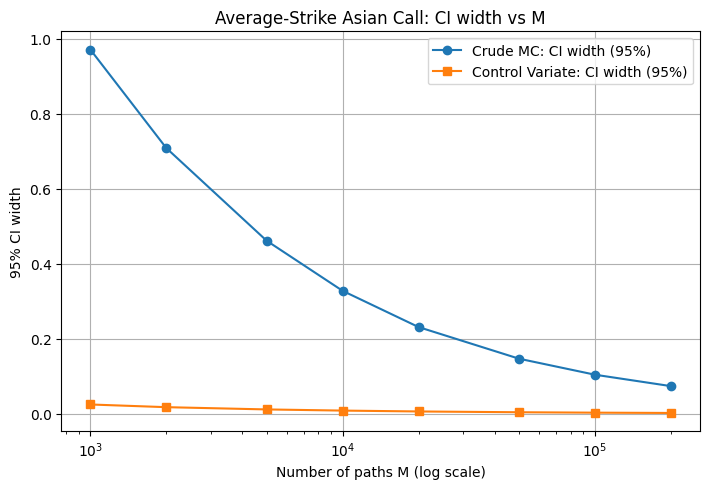

In [21]:
# Fixed problem inputs
S0, r, sigma, T = 100.0, 0.05, 0.20, 1.0
N = 50

M_list = [1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000, 200_000]
seed0 = 2025

rows = []
for M in M_list:
    out = estimate_asian_avg_strike(S0, r, sigma, T, N, M, seed=seed0)
    ciw_MC = out["ci_MC"][1] - out["ci_MC"][0]
    ciw_CV = out["ci_CV"][1] - out["ci_CV"][0]
    rows.append((M, out["price_MC"], ciw_MC, out["price_CV"], ciw_CV, out["var_red_pct"]))

print("M        Price_MC   CIw_MC      Price_CV   CIw_CV      VarRed%")
for M, p_mc, w_mc, p_cv, w_cv, vr in rows:
    print(f"{M:7d}  {p_mc:9.5f}  {w_mc:10.6f}  {p_cv:9.5f}  {w_cv:10.6f}  {vr:8.2f}")

# Plot: CI width vs M (log x-axis)
plt.figure()
plt.plot(M_list, [r[2] for r in rows], 'o-', label='Crude MC: CI width (95%)')
plt.plot(M_list, [r[4] for r in rows], 's-', label='Control Variate: CI width (95%)')
plt.xscale('log')
plt.xlabel("Number of paths M (log scale)")
plt.ylabel("95% CI width")
plt.title("Average-Strike Asian Call: CI width vs M")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
N_list = [10, 25, 50, 100, 200]
M_fixed = 100_000
seed0 = 2025

print("N      Price_MC   SE_MC     CIw_MC    Price_CV   SE_CV     CIw_CV    VarRed%   theta")
for N in N_list:
    out = estimate_asian_avg_strike(S0, r, sigma, T, N, M_fixed, seed=seed0)
    ciw_MC = out["ci_MC"][1] - out["ci_MC"][0]
    ciw_CV = out["ci_CV"][1] - out["ci_CV"][0]
    print(f"{N:6d}  {out['price_MC']:9.5f}  {out['se_MC']:8.6f}  {ciw_MC:9.6f}  "
          f"{out['price_CV']:9.5f}  {out['se_CV']:8.6f}  {ciw_CV:9.6f}  "
          f"{out['var_red_pct']:8.2f}  {out['theta']:7.3f}")


N      Price_MC   SE_MC     CIw_MC    Price_CV   SE_CV     CIw_CV    VarRed%   theta
    10    5.39603  0.024333   0.095383    4.98751  0.000578   0.002264     99.94    0.965
    25    5.67097  0.025933   0.101658    5.30083  0.000634   0.002486     99.94    0.967
    50    5.75964  0.026481   0.103804    5.40430  0.000655   0.002569     99.94    0.968
   100    5.81158  0.026669   0.104544    5.45671  0.000659   0.002585     99.94    0.968
   200    5.83919  0.026807   0.105084    5.48348  0.000664   0.002601     99.94    0.969


In [24]:
sigma_list = [0.10, 0.20, 0.30, 0.50]
N_fixed = 50
M_fixed = 100_000

print("sigma   Price_MC   SE_MC     CIw_MC    Price_CV   SE_CV     CIw_CV    VarRed%   theta")
for sig in sigma_list:
    out = estimate_asian_avg_strike(S0, r, sig, T, N_fixed, M_fixed, seed=2025)
    ciw_MC = out["ci_MC"][1] - out["ci_MC"][0]
    ciw_CV = out["ci_CV"][1] - out["ci_CV"][0]
    print(f"{sig:5.2f}  {out['price_MC']:9.5f}  {out['se_MC']:8.6f}  {ciw_MC:9.6f}  "
          f"{out['price_CV']:9.5f}  {out['se_CV']:8.6f}  {ciw_CV:9.6f}  "
          f"{out['var_red_pct']:8.2f}  {out['theta']:7.3f}")


sigma   Price_MC   SE_MC     CIw_MC    Price_CV   SE_CV     CIw_CV    VarRed%   theta
 0.10    3.63301  0.013676   0.053611    3.53281  0.000188   0.000737     99.98    0.983
 0.20    5.75964  0.026481   0.103804    5.40430  0.000655   0.002569     99.94    0.968
 0.30    7.95335  0.041079   0.161028    7.20696  0.001434   0.005623     99.88    0.953
 0.50   12.38076  0.077470   0.303683   10.50007  0.004057   0.015903     99.73    0.926
